# Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pyarrow.parquet as pq
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import findspark
findspark.init()
from pyspark.sql import SparkSession, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
#import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
base_dir = '/home/ytakahashi/project/kaggle/PLAsTiCC'

# Extracting Features from train set

In [2]:
gc.enable()

train = pq.read_table(os.path.join(base_dir, 'data/training_set.parquet')).to_pandas()
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}



In [5]:
%%time
agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train
gc.collect()

CPU times: user 4.8 s, sys: 696 ms, total: 5.49 s
Wall time: 4.29 s


# Merging extracted features with meta data

In [3]:
meta_train = pd.read_csv(os.path.join(base_dir, 'data/training_set_metadata.csv'))
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [4]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Standard Scaling the input (imp.)

In [5]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

# Deep Learning Begins...

In [6]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [8]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

# Defining simple model in keras

In [9]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [10]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

# Calculating the class weights

In [11]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [12]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

In [26]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

KeyboardInterrupt: 

In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [17]:
sample_sub = pd.read_csv(os.path.join(base_dir, 'data/sample_submission.csv'))
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

15723

Normalized confusion matrix
[[6.95e-01 0.00e+00 3.31e-02 0.00e+00 0.00e+00 3.31e-02 0.00e+00 0.00e+00
  1.46e-01 0.00e+00 0.00e+00 0.00e+00 9.27e-02 0.00e+00]
 [2.02e-03 4.10e-01 2.02e-03 6.87e-02 9.49e-02 0.00e+00 6.06e-02 4.44e-02
  2.02e-03 1.90e-01 8.08e-03 8.89e-02 0.00e+00 2.83e-02]
 [4.33e-03 0.00e+00 9.58e-01 0.00e+00 0.00e+00 1.08e-03 0.00e+00 0.00e+00
  6.49e-03 0.00e+00 0.00e+00 0.00e+00 3.03e-02 0.00e+00]
 [2.51e-03 1.77e-01 0.00e+00 1.88e-01 1.50e-01 8.38e-04 1.04e-01 6.54e-02
  8.38e-04 1.44e-01 1.01e-02 1.30e-01 0.00e+00 2.77e-02]
 [0.00e+00 1.75e-01 0.00e+00 8.20e-02 2.57e-01 0.00e+00 7.10e-02 4.37e-02
  0.00e+00 1.53e-01 0.00e+00 1.97e-01 0.00e+00 2.19e-02]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.33e-01 0.00e+00 0.00e+00
  3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.31e-01 0.00e+00 7.64e-02 1.07e-01 0.00e+00 1.40e-01 8.68e-02
  4.13e-03 2.58e-01 2.07e-03 8.06e-02 0.00e+00 1.24e-02]
 [9.80e-03 9.80e-03 0.00e+00 0.00e+00 9.80e-03 0.00e+00

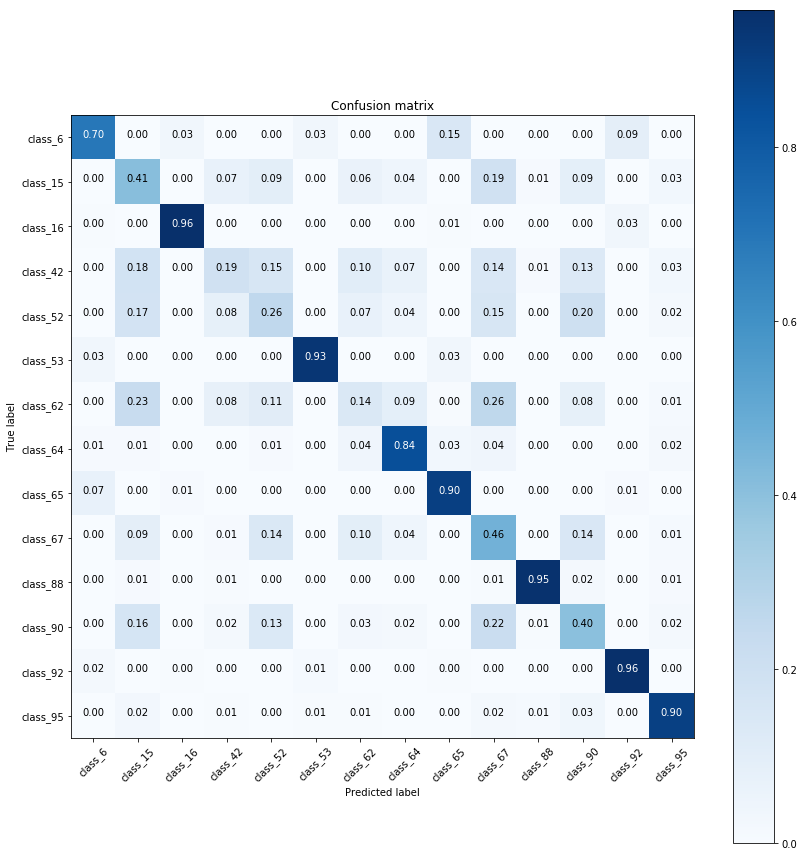

In [18]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')


# Test Set Predictions

In [45]:
meta_test = pd.read_csv(os.path.join(base_dir, 'data/test_set_metadata.csv'))
df = pd.read_parquet(os.path.join(base_dir, 'data/test_set.parquet'))

df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']

In [30]:
# Group by object id
%time agg_test = df.groupby('object_id').agg(aggs)
%time agg_test.columns = new_columns
%time agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
%time agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
%time agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
%time agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
%time agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

CPU times: user 1h 3min 10s, sys: 2min 50s, total: 1h 6min
Wall time: 1h 1min 56s
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 1.41 ms
CPU times: user 148 ms, sys: 224 ms, total: 372 ms
Wall time: 9.99 ms
CPU times: user 84 ms, sys: 296 ms, total: 380 ms
Wall time: 10.2 ms
CPU times: user 240 ms, sys: 444 ms, total: 684 ms
Wall time: 17.9 ms
CPU times: user 96 ms, sys: 252 ms, total: 348 ms
Wall time: 9.1 ms
CPU times: user 180 ms, sys: 376 ms, total: 556 ms
Wall time: 14.4 ms


In [ ]:
del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()

# Merge with meta data
full_test = agg_test.reset_index().merge(
    right=meta_test,
    how='left',
    on='object_id'
)

full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)

In [21]:
full_test_ss = ss.transform(full_test[full_train.columns])
# Make predictions
preds = None
for clf in clfs:
    if preds is None:
        preds = clf.predict_proba(full_test_ss) / folds.n_splits
    else:
        preds += clf.predict_proba(full_test_ss) / folds.n_splits

# Compute preds_99 as the proba of class not being any of the others
# preds_99 = 0.1 gives 1.769
preds_99 = np.ones(preds.shape[0])
for i in range(preds.shape[1]):
    preds_99 *= (1 - preds[:, i])
    
# Store predictions
preds_df = pd.DataFrame(preds, columns=class_names)
preds_df['object_id'] = full_test['object_id']
preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
preds_df.to_csv(os.path.join(base_dir, 'result/kernel_NN.csv'),float_format='%.8f', index=False)

del agg_test, full_test, preds_df, preds

KeyboardInterrupt: 

In [20]:
meta_test = pd.read_csv(os.path.join(base_dir, 'data/test_set_metadata.csv'))

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv(os.path.join(base_dir, 'data/test_set.csv'), chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

FileNotFoundError: File b'/home/ytakahashi/project/kaggle/PLAsTiCC/data/test_set.csv' does not exist

In [ ]:
z = pd.read_csv(os.path.join(base_dir, 'result/kernel_NN.csv'))

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv(os.path.join(base_dir, 'result/single_predictions'), index=True)

In [ ]:
z.head()

In [23]:
import tensorflow_gpu

ImportError: No module named 'tensorflow_gpu'

In [25]:
tf.test.is_gpu_available()

True

## Spark Preprocessing

In [3]:
spark = SparkSession.builder \
    .master("yarn-client") \
    .appName('plastic') \
    .config(key='spark.driver.memory', value='12g') \
    .config(key='spark.driver.extraJavaOptions', value='-Djava.io.tmpdir=/work1/ytakahashi/tmp') \
    .config(key='spark.default.parallelism', value='32') \
    .config(key='spark.executor.memory', value='20g') \
    .getOrCreate()

In [ ]:
%%time

train_sdf = spark.createDataFrame(train)
train_sdf = train_sdf.repartition(32,'object_id')
from pyspark.sql import functions as F
aggs4spark = [
    F.min(train_sdf.mjd), F.max(train_sdf.mjd),F.count(train_sdf.mjd),
    F.min(train_sdf.passband), F.max(train_sdf.passband), F.mean(train_sdf.passband),
    F.min(train_sdf.flux), F.max(train_sdf.flux),F.mean(train_sdf.flux),F.stddev(train_sdf.flux),
    F.min(train_sdf.flux_err), F.max(train_sdf.flux_err),F.mean(train_sdf.flux_err),F.stddev(train_sdf.flux_err),
    F.mean(train_sdf.detected), F.sum(train_sdf.flux_ratio_sq), F.sum(train_sdf.flux_by_flux_ratio_sq)
]
obj_grouped = train_sdf.groupBy(train_sdf.object_id)
train_agg_sdf = obj_grouped.agg(*aggs4spark)
train_agg_sdf = train_agg_sdf.withColumn('mjd_diff', train_agg_sdf['max(mjd)'] - train_agg_sdf['min(mjd)'])
train_agg_sdf = train_agg_sdf.withColumn('flux_diff', train_agg_sdf['max(flux)'] - train_agg_sdf['min(flux)'])
train_agg_sdf = train_agg_sdf.withColumn('flux_dif2', (train_agg_sdf['max(flux)'] - train_agg_sdf['min(flux)'])/train_agg_sdf['avg(flux)'])
train_agg_sdf = train_agg_sdf.withColumn('flux_w_mean', train_agg_sdf['sum(flux_by_flux_ratio_sq)'] - train_agg_sdf['sum(flux_ratio_sq)'])
train_agg_sdf = train_agg_sdf.withColumn('flux_dif3', (train_agg_sdf['max(flux)'] - train_agg_sdf['min(flux)'])/train_agg_sdf['flux_w_mean'])

train_agged = train_agg_sdf.toPandas()